# Import Package, and Func.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pyscf import gto, scf, fci
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import AerSimulator, AerProvider

# To run on hardware, select the backend with the fewest number of jobs in the queue
#service = QiskitRuntimeService(channel="ibm_quantum", token ='55ac54cb4cbfe378d8604606bacfcab38ffd165ecdb215742e64495a259fa53f0ed9e63df5b3df4489d422865a007d9cc981fcb2caffd9e76f17d94d734a8593')
#backend = service.least_busy(operational=True, simulator=False)
#backend = GenericBackendV2(num_qubits=5)

backend = AerSimulator(method = "statevector",noise_model=None)

ModuleNotFoundError: No module named 'qiskit_ibm_runtime'

In [ ]:
'''
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit_nature import settings
from qiskit_algorithms.optimizers import  SPSA, COBYLA, L_BFGS_B

from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit.primitives import Estimator

from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator
'''


'\nfrom qiskit_nature.second_q.transformers import ActiveSpaceTransformer\nfrom qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver\nfrom qiskit_nature import settings\nfrom qiskit_algorithms.optimizers import  SPSA, COBYLA, L_BFGS_B\n\nfrom qiskit.circuit.library import TwoLocal\nfrom qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE\nfrom qiskit.primitives import Estimator\n\nfrom qiskit_ibm_runtime import Session\nfrom qiskit_ibm_runtime.fake_provider import FakeManilaV2\nfrom qiskit_ibm_runtime import QiskitRuntimeService\nfrom qiskit_ibm_runtime import EstimatorV2 as Estimator\n'

In [ ]:
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

In [ ]:

def fermion_to_qubit(problem, second_q_op, mapper_name,  z2symmetry_reduction=None):
  if mapper_name == "JW":
    mapper = JordanWignerMapper()
  if mapper_name == "Pa":
    mapper = ParityMapper(num_particles=problem.num_particles)
  if mapper_name == "BK":
    mapper = BravyiKitaevMapper()

  qubit_op = mapper.map(second_q_op)

  if z2symmetry_reduction != None:
    mapper = problem.get_tapered_mapper(mapper)
    qubit_op = mapper.map(second_q_op)
  else :
    qubit_op = mapper.map(second_q_op)

  return qubit_op , mapper

def FCI(dist):
    # 1. 분자 정의
    mol = gto.M(
        atom = 'H 0 0 0; H 0 0 {}'.format(dist),  # 수소 원자 2개, 거리 0.74 Å
        basis = 'sto-3g',              # 간단한 기저함수
        unit = 'Angstrom',
        spin = 0,                      # 전자 수 = 2, 총 spin = 0 (singlet)
        charge = 0
    )

    # 2. Hartree-Fock 계산
    mf = scf.RHF(mol)
    hf_energy = mf.kernel()

    # 3. FCI 계산 (Full CI)
    cisolver = fci.FCI(mol, mf.mo_coeff)
    fci_energy, fci_vector = cisolver.kernel()

    return fci_energy

In [ ]:
atoms = ["H", "H"]
basis = 'sto3g'
dist = 0.735
coords = [(0,0,0), (dist,0,0)]
charge = 0
multiplicity = 1
Co_O_moleculeinfo = MoleculeInfo(atoms, coords, charge=charge, multiplicity=multiplicity)
driver = PySCFDriver.from_molecule(Co_O_moleculeinfo, basis=basis)
E_problem = driver.run() # 여기는 이후, As_transformer 로 변경. 

In [1]:
fermionic_hamiltonian = E_problem.hamiltonian
second_q_op = fermionic_hamiltonian.second_q_op()
print(second_q_op)
repulsion = fermionic_hamiltonian.constants['nuclear_repulsion_energy']
hamiltonian, mapper = fermion_to_qubit(E_problem, second_q_op, "JW", z2symmetry_reduction=None)
print(hamiltonian)

NameError: name 'E_problem' is not defined

In [9]:
print(repulsion)

0.7199689944489797


In [10]:
num_particles = E_problem.num_particles
num_spatial_orbitals = E_problem.num_spatial_orbitals

init_state = HartreeFock(num_spatial_orbitals,num_particles,mapper)
ansatz = UCCSD(num_spatial_orbitals,num_particles,mapper,initial_state=init_state)

In [11]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

In [12]:
#ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [13]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout) # 그니까 컴파일 된거.
print(hamiltonian_isa)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.81054798+0.j,  0.17218393+0.j, -0.22575349+0.j,  0.17218393+0.j,
 -0.22575349+0.j,  0.12091263+0.j,  0.16892754+0.j,  0.16614543+0.j,
  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,
  0.16614543+0.j,  0.17464343+0.j,  0.12091263+0.j])


In [14]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [15]:
num_params = ansatz.num_parameters
x0 = 2 * np.pi * np.random.random(num_params)

In [16]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

Iters. done: 1 [Current cost: -1.4063288163285732]
Iters. done: 2 [Current cost: -0.935928907357367]
Iters. done: 3 [Current cost: -0.7120840835505299]
Iters. done: 4 [Current cost: -0.9253052357256958]
Iters. done: 5 [Current cost: -1.3995876392990192]
Iters. done: 6 [Current cost: -1.55899994346289]
Iters. done: 7 [Current cost: -1.2061315694370065]
Iters. done: 8 [Current cost: -1.567313585053124]
Iters. done: 9 [Current cost: -1.099090568688693]
Iters. done: 10 [Current cost: -1.596596693322797]
Iters. done: 11 [Current cost: -1.6234940786429843]
Iters. done: 12 [Current cost: -1.5829557894291613]
Iters. done: 13 [Current cost: -1.6034907265644167]
Iters. done: 14 [Current cost: -1.6569439210334733]
Iters. done: 15 [Current cost: -1.6613297785653585]
Iters. done: 16 [Current cost: -1.689934376334592]
Iters. done: 17 [Current cost: -1.7011697928282383]
Iters. done: 18 [Current cost: -1.7188039591537891]
Iters. done: 19 [Current cost: -1.7397710044286945]
Iters. done: 20 [Current cos

converged SCF energy = -1.116998996754


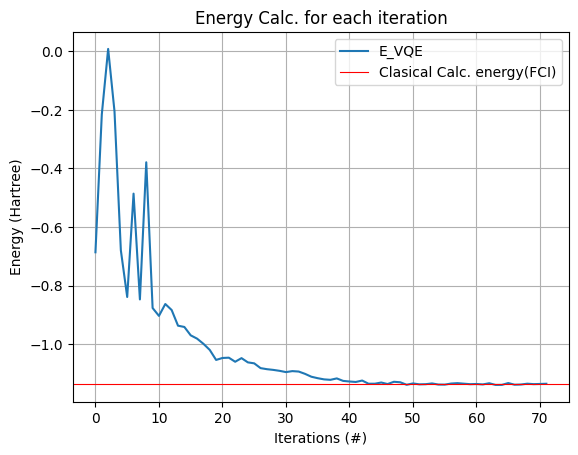

In [24]:
E_exact = FCI(dist)


plt.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"] + repulsion, label='E_VQE')
plt.axhline(E_exact, color = 'r', linewidth = 0.8, label = 'Clasical Calc. energy(FCI)')
plt.xlabel("Iterations (#)")
plt.ylabel("Energy (Hartree)")
plt.title("Energy Calc. for each iteration")
plt.legend()
plt.grid()
plt.draw()